## Method
*Similar to experiment_12_2 but add MSE measure
- Normalize prediction risk maps (0, 1)
- Get maximum prediction risk map based on risk matrix obtained from different DB (experiment_10_2_SEPPexp...)
- Measure hit rate, PAI and MSE considering different ground truth scenarios:
    1. SIEDCO
    2. RNMC
    3. NUSE

## Hypothesis: 
MSE between multimodal prediction (using maximum operator) and ground truth maps (by DB) is higher than MSEs obtained on unimodal scenario but lower than multimodal-average results.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("..")
import geojson
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from pyproj import Proj, transform
import pickle
import open_cp

In [2]:
from services import prediction_metrics
from services.prediction_experiment import PredictionExperiment
from services.process_data import ProcessData

Failed to import `rtree`.
Failed to import `rtree`.


## Built-in

In [3]:
def get_hit_rate_from_dict(row,column,coverage):
    return row[column][coverage]

In [4]:
def average_grid_prediction(row):
    xoffset_avg = (row['prediction_siedco']._xoffset + row['prediction_rnmc']._xoffset + row['prediction_nuse']._xoffset)/3
    yoffset_avg = (row['prediction_siedco']._yoffset + row['prediction_rnmc']._yoffset + row['prediction_nuse']._yoffset)/3
    xsize_avg = (row['prediction_siedco']._xsize + row['prediction_rnmc']._xsize + row['prediction_nuse']._xsize)/3
    ysize_avg = (row['prediction_siedco']._ysize + row['prediction_rnmc']._ysize + row['prediction_nuse']._ysize)/3
    matrix_avg = (row['prediction_siedco']._matrix + row['prediction_rnmc']._matrix + row['prediction_nuse']._matrix)/3
    return open_cp.predictors.GridPredictionArray(xsize=xsize_avg,ysize=ysize_avg,matrix=matrix_avg,xoffset=xoffset_avg,yoffset=yoffset_avg)

In [5]:
import operator

def maximum_grid_prediction(row):
    max_intensity = {}
    max_intensity['siedco']=np.sum(row['prediction_siedco']._matrix)
    max_intensity['rnmc']=np.sum(row['prediction_rnmc']._matrix)
    max_intensity['nuse']=np.sum(row['prediction_nuse']._matrix)
    key_max_intensity = max(max_intensity.items(), key=operator.itemgetter(1))[0]
    
    column = 'prediction_'+str(key_max_intensity)
    xoffset_max = row[column]._xoffset
    yoffset_max = row[column]._yoffset
    xsize_max = row[column]._xsize
    ysize_max = row[column]._ysize
    matrix_max = row[column]._matrix
    return open_cp.predictors.GridPredictionArray(xsize=xsize_max,ysize=ysize_max,matrix=matrix_max,xoffset=xoffset_max,yoffset=yoffset_max)


In [6]:
def normalize_grid_prediction(row, column_name):
    xoffset = row[column_name]._xoffset
    yoffset = row[column_name]._yoffset
    xsize = row[column_name]._xsize
    ysize = row[column_name]._ysize
    matrix_norm = row[column_name]._matrix.copy()
    # Uses 1 division and matix.size multiplications, multiplication is faster than division
    matrix_norm *= 1/row[column_name]._matrix.max()
    return open_cp.predictors.GridPredictionArray(xsize=xsize,ysize=ysize,matrix=matrix_norm,xoffset=xoffset,yoffset=yoffset)
    

## Load prediction results

In [7]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_2_siedco_prediction.pkl','rb')
loaded_siedco = pickle.load(infile)
infile.close()

In [8]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_2_rnmc_prediction.pkl','rb')
loaded_rnmc = pickle.load(infile)
infile.close()

In [9]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_2_nuse_prediction.pkl','rb')
loaded_nuse = pickle.load(infile)
infile.close()

## Normalize prediction intensity risk maps

In [10]:
loaded_siedco['prediction_normalized'] = loaded_siedco.apply(lambda row: normalize_grid_prediction(row,'prediction'), axis=1)
loaded_rnmc['prediction_normalized'] = loaded_rnmc.apply(lambda row: normalize_grid_prediction(row,'prediction'), axis=1)
loaded_nuse['prediction_normalized'] = loaded_nuse.apply(lambda row: normalize_grid_prediction(row,'prediction'), axis=1)


## Compute maximum prediction

In [11]:
loaded_siedco = loaded_siedco.rename(columns={'prediction_normalized': 'prediction_siedco', 'eval_pts': 'eval_pts_siedco'})
loaded_rnmc = loaded_rnmc.rename(columns={'prediction_normalized': 'prediction_rnmc', 'eval_pts': 'eval_pts_rnmc'})
loaded_nuse = loaded_nuse.rename(columns={'prediction_normalized': 'prediction_nuse', 'eval_pts': 'eval_pts_nuse'})

In [12]:
result = pd.concat([loaded_siedco, loaded_rnmc, loaded_nuse], axis=1)

In [13]:
result['max_prediction'] = result.apply(lambda row: maximum_grid_prediction(row), axis=1)

## Hit rate, PAI and MSE

#### Real percentage of city coverage over rectangular region (based on script experiment_11_1_get_rectangular_city_region):

In [14]:
city_percentage_on_region = 0.26

In [15]:
## coverages are represented in % (NOT IN PROPORTION)
coverages = [2,4,6,8,10,12,14,16,18,20]
### this approach is only used to open_cp hit rate implementation method makes sense
real_coverages_city = list(map(lambda c: round((c/100)*city_percentage_on_region*100, 1), coverages))

In [16]:
## coverages are represented in % (NOT IN PROPORTION)
real_coverages_city

[0.5, 1.0, 1.6, 2.1, 2.6, 3.1, 3.6, 4.2, 4.7, 5.2]

### SIEDCO ground truth

In [17]:
df_result = result.copy()

In [18]:
df_result['hitrate_default'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['max_prediction'],row['eval_pts_siedco'],real_coverages_city,'default'), axis=1)
df_result['hitrate_TP'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['max_prediction'],row['eval_pts_siedco'],real_coverages_city,'ground_truth_coverage'), axis=1)


In [19]:
##For hitrate_TP "true positives"
df_result['coverage_TP'] = df_result.apply(lambda row: (list(row['hitrate_TP'].keys())[0])/city_percentage_on_region, axis=1)
df_result['hit_rate_TP'] = df_result.apply(lambda row: list(row['hitrate_TP'].values())[0], axis=1)
df_result['PAI_TP'] = df_result['hit_rate_TP'] / (df_result['coverage_TP']/100)

In [20]:
##For hitrate_default
#coverages = [2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0]
column_dict = 'hitrate_default'
for c in real_coverages_city:
    new_hit_rate_column = 'hit_rate_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_hit_rate_column] = df_result.apply(lambda row: get_hit_rate_from_dict(row,column_dict,c), axis=1)

    ##PAI
    new_column = 'PAI_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_column] = df_result[new_hit_rate_column]/(round(c/city_percentage_on_region)/100)


In [21]:
## MSE
df_result['MSE'] = df_result.apply(lambda row: prediction_metrics.mse(row['max_prediction'],row['eval_pts_siedco']), axis=1)


In [22]:
#delete datetimes where no crimes were reported (0 crimes on ground truth -> hit-rate = -1)
df_result = df_result[df_result['hit_rate_default_coverage_2']!= -1]
print(df_result.mean())

coverage_TP                     0.020564
hit_rate_TP                     0.000000
PAI_TP                          0.000000
hit_rate_default_coverage_2     0.198390
PAI_default_coverage_2          9.919509
hit_rate_default_coverage_4     0.338189
PAI_default_coverage_4          8.454731
hit_rate_default_coverage_6     0.472689
PAI_default_coverage_6          7.878157
hit_rate_default_coverage_8     0.525644
PAI_default_coverage_8          6.570548
hit_rate_default_coverage_10    0.525644
PAI_default_coverage_10         5.256439
hit_rate_default_coverage_12    0.525644
PAI_default_coverage_12         4.380366
hit_rate_default_coverage_14    0.525644
PAI_default_coverage_14         3.754599
hit_rate_default_coverage_16    0.525644
PAI_default_coverage_16         3.285274
hit_rate_default_coverage_18    0.525644
PAI_default_coverage_18         2.920244
hit_rate_default_coverage_20    0.525644
PAI_default_coverage_20         2.628219
MSE                             0.000089
dtype: float64


### RNMC ground truth

In [23]:
df_result = result.copy()

In [24]:
df_result['hitrate_default'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['max_prediction'],row['eval_pts_rnmc'],real_coverages_city,'default'), axis=1)
df_result['hitrate_TP'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['max_prediction'],row['eval_pts_rnmc'],real_coverages_city,'ground_truth_coverage'), axis=1)


In [25]:
##For hitrate_TP "true positives"
df_result['coverage_TP'] = df_result.apply(lambda row: (list(row['hitrate_TP'].keys())[0])/city_percentage_on_region, axis=1)
df_result['hit_rate_TP'] = df_result.apply(lambda row: list(row['hitrate_TP'].values())[0], axis=1)
df_result['PAI_TP'] = df_result['hit_rate_TP'] / (df_result['coverage_TP']/100)

In [26]:
##For hitrate_default
#coverages = [2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0]
column_dict = 'hitrate_default'
for c in real_coverages_city:
    new_hit_rate_column = 'hit_rate_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_hit_rate_column] = df_result.apply(lambda row: get_hit_rate_from_dict(row,column_dict,c), axis=1)

    ##PAI
    new_column = 'PAI_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_column] = df_result[new_hit_rate_column]/(round(c/city_percentage_on_region)/100)


In [28]:
## MSE
df_result['MSE'] = df_result.apply(lambda row: prediction_metrics.mse(row['max_prediction'],row['eval_pts_rnmc']), axis=1)


In [29]:
#delete datetimes where no crimes were reported (0 crimes on ground truth -> hit-rate = -1)
df_result = df_result[df_result['hit_rate_default_coverage_2']!= -1]
print(df_result.mean())

coverage_TP                       0.124019
hit_rate_TP                       0.133222
PAI_TP                          108.963108
hit_rate_default_coverage_2       0.518141
PAI_default_coverage_2           25.907043
hit_rate_default_coverage_4       0.662509
PAI_default_coverage_4           16.562716
hit_rate_default_coverage_6       0.755519
PAI_default_coverage_6           12.591988
hit_rate_default_coverage_8       0.804676
PAI_default_coverage_8           10.058450
hit_rate_default_coverage_10      0.804676
PAI_default_coverage_10           8.046760
hit_rate_default_coverage_12      0.804676
PAI_default_coverage_12           6.705633
hit_rate_default_coverage_14      0.804676
PAI_default_coverage_14           5.747686
hit_rate_default_coverage_16      0.804676
PAI_default_coverage_16           5.029225
hit_rate_default_coverage_18      0.804676
PAI_default_coverage_18           4.470422
hit_rate_default_coverage_20      0.804676
PAI_default_coverage_20           4.023380
MSE        

### NUSE ground truth

In [30]:
df_result = result.copy()

In [31]:
df_result['hitrate_default'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['max_prediction'],row['eval_pts_nuse'],real_coverages_city,'default'), axis=1)
df_result['hitrate_TP'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['max_prediction'],row['eval_pts_nuse'],real_coverages_city,'ground_truth_coverage'), axis=1)


In [32]:
##For hitrate_TP "true positives"
df_result['coverage_TP'] = df_result.apply(lambda row: (list(row['hitrate_TP'].keys())[0])/city_percentage_on_region, axis=1)
df_result['hit_rate_TP'] = df_result.apply(lambda row: list(row['hitrate_TP'].values())[0], axis=1)
df_result['PAI_TP'] = df_result['hit_rate_TP'] / (df_result['coverage_TP']/100)

In [33]:
##For hitrate_default
#coverages = [2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0]
column_dict = 'hitrate_default'
for c in real_coverages_city:
    new_hit_rate_column = 'hit_rate_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_hit_rate_column] = df_result.apply(lambda row: get_hit_rate_from_dict(row,column_dict,c), axis=1)

    ##PAI
    new_column = 'PAI_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_column] = df_result[new_hit_rate_column]/(round(c/city_percentage_on_region)/100)


In [34]:
## MSE
df_result['MSE'] = df_result.apply(lambda row: prediction_metrics.mse(row['max_prediction'],row['eval_pts_nuse']), axis=1)


In [35]:
#delete datetimes where no crimes were reported (0 crimes on ground truth -> hit-rate = -1)
df_result = df_result[df_result['hit_rate_default_coverage_2']!= -1]
print(df_result.mean())

coverage_TP                     0.365678
hit_rate_TP                     0.033797
PAI_TP                          9.609092
hit_rate_default_coverage_2     0.167902
PAI_default_coverage_2          8.395106
hit_rate_default_coverage_4     0.308585
PAI_default_coverage_4          7.714634
hit_rate_default_coverage_6     0.447195
PAI_default_coverage_6          7.453255
hit_rate_default_coverage_8     0.483228
PAI_default_coverage_8          6.040351
hit_rate_default_coverage_10    0.483228
PAI_default_coverage_10         4.832281
hit_rate_default_coverage_12    0.483228
PAI_default_coverage_12         4.026900
hit_rate_default_coverage_14    0.483228
PAI_default_coverage_14         3.451629
hit_rate_default_coverage_16    0.483228
PAI_default_coverage_16         3.020175
hit_rate_default_coverage_18    0.483228
PAI_default_coverage_18         2.684600
hit_rate_default_coverage_20    0.483228
PAI_default_coverage_20         2.416140
MSE                             0.000138
dtype: float64


## MSE summary results

/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x1236a3208>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  from ipykernel import kernelapp as app
/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x12eacdb70>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  from ipykernel import kernelapp as app
/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Legend does not support [<matplotlib.lines.Line2D 

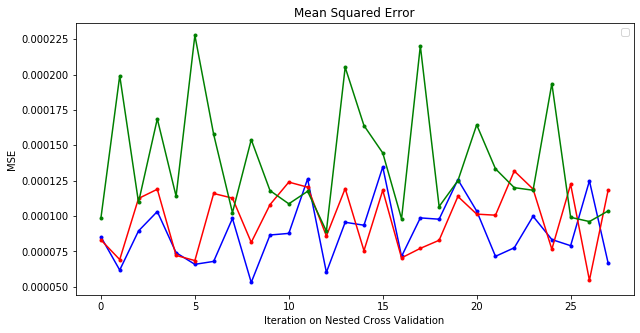

In [36]:
df_mse = result.copy()
df_mse['MSE_siedco'] = df_mse.apply(lambda row: prediction_metrics.mse(row['max_prediction'],row['eval_pts_siedco']), axis=1)
df_mse['MSE_rnmc'] = df_mse.apply(lambda row: prediction_metrics.mse(row['max_prediction'],row['eval_pts_rnmc']), axis=1)
df_mse['MSE_nuse'] = df_mse.apply(lambda row: prediction_metrics.mse(row['max_prediction'],row['eval_pts_nuse']), axis=1)

fig, ax = plt.subplots(figsize=(10,5))
siedco = ax.plot(df_mse.index.values, df_mse['MSE_siedco'].values, marker=".",color='blue')
rnmc = ax.plot(df_mse.index.values, df_mse['MSE_rnmc'].values, marker=".",color='red')
nuse = ax.plot(df_mse.index.values, df_mse['MSE_nuse'].values, marker=".",color='green')
#multimodal_average = ax.scatter(result.index.values,result['multimodal_average_entropy'].values, marker=".",color='orange')
#multimodal_max = ax.scatter(result.index.values,result['multimodal_max_entropy'].values, marker=".",color='blue')
#multimodal_max_cell = ax.scatter(result.index.values,result['multimodal_max_cell_entropy'].values, marker=".",color='black')
ax.set_title('Mean Squared Error')
#ax.set_ylim(0,0.00020)
ax.legend((siedco, rnmc, nuse),('siedco', 'rnmc', 'nuse'))
plt.xlabel('Iteration on Nested Cross Validation')
plt.ylabel('MSE')
plt.show()